# Navigation

---

In this project, we develop a Deep Q-Learning agent that utilises its newly acquired skills to navigate in a large, square example world and collect bananas. A reward of +1 is provided for collecting a yellow banana, and a reward of -1 is provided for collecting a blue banana. Thus, the goal of your agent is to collect as many yellow bananas as possible while avoiding blue bananas.

### 0. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

### 1. Set environment parameters

Here we set `env_name` to the name of the Unity environment file we want to launch. We should ensure that the environment build is in the `python/` directory.

In [2]:
env_name = "/data/Banana_Linux_NoVis/Banana.x86_64"  # Name of the Unity environment binary to launch
train_mode = True                                    # Whether to run the environment in training or inference mode

### 2. Load dependencies

The following loads the necessary dependencies and checks the Python version (at runtime). ML-Agents Toolkit (v0.3 onwards) requires Python 3.

In [3]:
import sys
import random
import matplotlib.pyplot as plt

from collections import namedtuple, deque

from unityagents import UnityEnvironment

%matplotlib inline

print("Python version:")
print(sys.version)

# check Python version
if (sys.version_info[0] < 3):
    raise Exception("ERROR: ML-Agents Toolkit (v0.3 onwards) requires Python 3")

Python version:
3.6.3 | packaged by conda-forge | (default, Nov  4 2017, 10:10:56) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


### 3. Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

In [4]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name=env_name, no_graphics=False) # Set graphics to False so we do not overload the system

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 4. Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

The state space has 37 dimensions and contains the agent's velocity, along with ray-based perception of objects around the agent's forward direction. Given this information, the agent has to learn how to best select actions. Four discrete actions are available, corresponding to:
* move forward
* move backwards
* turn left
* turn right

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 5. Take random actions in the environment
Once we restart an environment, we can step the environment forward and provide actions to all of the agents within the environment. Here we simply choose random actions. 

Once this cell is executed, a message will be printed that detail how much reward was accumulated during one Episode. The Unity environment will then pause, waiting for further signals telling it what to do next. Thus, not seeing any animation is expected when running this cell.

In [7]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


### 6. Training the agent

Now let us train our agent to solve the environment!

#### 6.1 Model Definition

We define a simple Neural Network, that works as a function approximation for the true action-value funtion. The network has three simple dense layers, with `ReLU` activation functions, except for the last one, that essentially has an identity activation function.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        """Initialize and build model.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
            fc1_units (int): number of nodes in first hidden layer
            fc2_units (int): number of nodes in second hidden layer
        """
        super(QNetwork, self).__init__()
        
        self.seed = torch.manual_seed(seed) # initialize network weights
        # create network layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values.
        
        Params
        ======
            state (list): the problem's state representation
        """
        # create feed forward process
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

#### 6.2 DQN Agent

Next, we create the experience replay buffer class, as well as the DQN agent that solves the environment. Last but not least, we create a method that implements the DQN algorithm and trains the agent.

In [9]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [10]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, buffer_size, batch_size, update_every,
                 gamma=0.99, tau=1e-3, lr=1e-3, seed=0):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            buffer_size (int): replay buffer size
            batch_size (int): minibatch size
            update_every (int): how often to update the network
            gamma (float): discount factor
            tau (float): for soft update of target parameters
            lr (float): learning rate
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=lr)
        self.update_every = update_every

        # Replay memory
        self.memory = ReplayBuffer(action_size, buffer_size, batch_size, seed)
        self.t_step = 0 # Initialize time step
    
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done) # Save experience in replay memory
        
        # Learn every 'update_every' time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)
    
    def act(self, state, eps = .0):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, self.tau)  
    
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [13]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """ Deep Q-Learning Algorithm.
    
    Params:
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # initialize scores list
    scores_window = deque(maxlen=100)  # Keep only the 100 latest scores
    eps = eps_start                    # initialize epsilon
    for e in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]           # get the current state
        score = 0                                         # initialize the score
        for t in range(max_t):
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]             # send the action to the environment
            next_state = env_info.vector_observations[0]        # get the next state
            reward = env_info.rewards[0]                        # get the reward
            done = env_info.local_done[0]                       # see if episode has finished
            agent.step(state, action, reward, next_state, done) # enable learning
            score += reward                                     # update the score
            state = next_state                                  # roll over the state to next time step
            if done:                                            # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        if e % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    
    return scores

#### 6.3 Training

We now run the DQN method to train our agent. The task is episodic, and in order to solve the environment, your agent must get an average score of +13 over 100 consecutive episodes.

In [14]:
# Initialize a DQN Agent
agent = Agent(state_size, action_size, int(1e5), 64, 4)

# Run the DQN algorithm
scores = dqn()

Episode 100	Average Score: 0.40
Episode 200	Average Score: 3.79
Episode 300	Average Score: 7.28
Episode 400	Average Score: 10.10

Environment solved in 485 episodes!	Average Score: 13.09


#### 6.4 Close the environment when finished
When we are finished using an environment, we can close it with the function below.

In [15]:
env.close()

### 7. Results
Here we plot the evolution of the score accumulated by our agent, by the number of episodes.

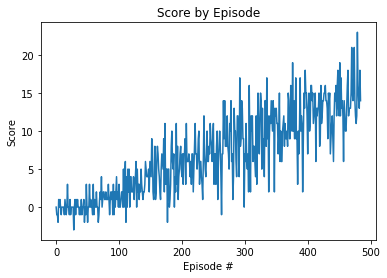

In [17]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.title("Score by Episode")
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()